In [1]:
# import shutil
# import os

# # Delete HateDeRC directory if it exists
# if os.path.exists('HateDeRC'):
#   shutil.rmtree('HateDeRC')
# !git clone https://github.com/jamesalv/HateDeRC
# %cd HateDeRC

In [2]:
from TrainingConfig import TrainingConfig
from typing import Dict, Any, Tuple, List
import numpy as np
import torch
from transformers import AutoTokenizer
import json

In [3]:
data_path = 'Data/dataset.json'

In [4]:
config = TrainingConfig()

config.class_weighting = True
config.learning_rate = 1e-5
config.batch_size = 32
config.num_epochs = 1
config.hidden_dropout_prob = 0.2

# Attention Training Configurations
config.lambda_attn = 1
config.ranking_margin = 0.1        # Minimum margin between token pairs
config.ranking_threshold = 0.05    # Min difference to consider pairs significant

# Loss Weights
config.lower_loss_weight = 0.5
config.upper_loss_weight = 0.5

In [5]:
ablations = [
  # {
  #   "model_name": "bert-base-uncased",
  #   "train_attention": True,
  #   "use_multi_layer_loss": True,
  # },
  # {
  #   "model_name": "bert-base-uncased",
  #   "train_attention": True,
  #   "use_multi_layer_loss": False,
  # },
  # {
  #   "model_name": "bert-base-uncased",
  #   "train_attention": False,
  #   "use_multi_layer_loss": False,
  # },
  {
    "model_name": "distilbert-base-uncased",
    "train_attention": True,
    "use_multi_layer_loss": True,
  },
  # {
  #   "model_name": "distilbert-base-uncased",
  #   "train_attention": True,
  #   "use_multi_layer_loss": False,
  # },
  {
    "model_name": "distilbert-base-uncased",
    "train_attention": False,
    "use_multi_layer_loss": False,
  },
  # {
  #   "model_name": "microsoft/deberta-v3-base",
  #   "train_attention": True,
  #   "use_multi_layer_loss": True,
  # },
  # {
  #   "model_name": "microsoft/deberta-v3-base",
  #   "train_attention": True,
  #   "use_multi_layer_loss": False,
  # },
  # {
  #   "model_name": "microsoft/deberta-v3-base",
  #   "train_attention": False,
  #   "use_multi_layer_loss": False,
  # }
]

In [6]:
# Seed all randomness for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(config.seed)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(config.seed)
np.random.seed(config.seed)

In [7]:
from preprocessing import process_and_convert_data
from HateDataset import HateDataset
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from itertools import chain
from bias_evaluation import calculate_gmb_metrics
from HateInterpreter import HateInterpreter
from ExperimentManager import ExperimentManager
from HateClassifier import HateClassifier

for ablation in ablations:
  for key, value in ablation.items():
    setattr(config, key, value)

  print(f"\nStarting experiment with config: {ablation}\n")

  # Initialize Experiment Manager
  experiment_manager = ExperimentManager(base_dir="./experiments")
  experiment_dir = experiment_manager.create_experiment(
      config=config,
      custom_name=f"{config.model_name}_attention_{config.train_attention}_multiLayerLoss_{config.use_multi_layer_loss}"
  )
  
  # PREPROCESSING
  with open(data_path, 'r') as file:
    data = json.load(file)

  with open('Data/post_id_divisions.json') as file:
      post_id_divisions = json.load(file)

  # Process everything in one pass
  tokenizer = AutoTokenizer.from_pretrained(config.model_name)
  splits = process_and_convert_data(
      data=data,
      tokenizer=tokenizer,
      post_id_divisions=post_id_divisions,
      save_path='Data/explanations/',
      drop_abnormal=False
  )

  # Access splits directly
  train_data = splits['train']
  val_data = splits['val']
  test_data = splits['test']

  # Create datasets with pre-tokenized data
  train_dataset = HateDataset(data=train_data)
  val_dataset = HateDataset(data=val_data)
  test_dataset = HateDataset(data=test_data)
  
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # Use shuffle=False for validation
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Use shuffle=False for testing
  
  y = [int(td['hard_label']) for td in train_data]
  class_weights = torch.tensor(compute_class_weight(
      class_weight='balanced',
      classes=np.array([0, 1]),  # Ensure consistent order
      y=y
  ), dtype=torch.float32)
  
  # TRAINING
  model = HateClassifier(config, class_weight=class_weights)
  history = model.train(train_dataloader=train_loader, val_dataloader=val_loader)

  # Save training history
  experiment_manager.save_training_history(history)
  
  # EVALUATION
  model.load_model('best_model')

  # Evaluate performance on test set
  result = model.predict(test_dataloader=test_loader, return_attentions=True)

  # Save predictions
  experiment_manager.save_predictions(result, filename="test_predictions.pkl")
  
  # Evaluate Bias
  all_target_groups = chain.from_iterable([group['target_groups'] for group in train_data])
  all_target_groups = [group for group in all_target_groups if group != 'None' and group != 'Other']
  counter = Counter(all_target_groups)

  n_common = 10
  bias_target_groups = [tg[0] for tg in counter.most_common(n_common)]

  # 4. BIAS EVALUATION
  gmb_metrics, bias_details = calculate_gmb_metrics(
      test_data=test_data,
      probabilities=result['probabilities'],
      target_groups=bias_target_groups
  )

  # Save bias metrics
  experiment_manager.save_bias_metrics(gmb_metrics, bias_details)

  # 5. XAI EVALUATION (only on hate samples)
  test_data_hate_only = []
  test_results_hate_only = {'attentions': [], 'probabilities': [], 'predictions': [], 'post_id': [], 'labels': []}
  for idx, td in enumerate(test_data):
      if td['hard_label'] == 1:
          test_data_hate_only.append(td)
          test_results_hate_only['attentions'].append(result['attentions'][idx])
          test_results_hate_only['probabilities'].append(result['probabilities'][idx])
          test_results_hate_only['predictions'].append(result['predictions'][idx])
          test_results_hate_only['post_id'].append(result['post_ids'][idx])
          test_results_hate_only['labels'].append(result['labels'][idx])

  calculator = HateInterpreter(
      model=model,
      tokenizer=tokenizer,
      dataset_class=HateDataset,
      batch_size=32
  )

  k = 5
  eraser_save_path = f"{experiment_dir}/results/test_explain_output.jsonl"
  xai_results = calculator.compute_all_metrics(test_data_hate_only, test_results_hate_only, k, eraser_save_path)

  # Save XAI metrics
  experiment_manager.save_xai_metrics(xai_results)

  !git clone https://github.com/jayded/eraserbenchmark.git
  !sed -i "285s/.*/    labels=['0', '1']/" eraserbenchmark/rationale_benchmark/metrics.py
  !sed -i "286s/.*/    label_to_int = {'0':0, '1': 1}/" eraserbenchmark/rationale_benchmark/metrics.py
  
  score_file = f"{experiment_dir}/results/eraser_result.json"
  !PYTHONPATH=./eraserbenchmark:%PYTHONPATH% && python eraserbenchmark/rationale_benchmark/metrics.py --split test --strict --data_dir Data/explanations --results {eraser_save_path} --score_file {score_file}
  
  # Final Summary
  # 6. CREATE FINAL SUMMARY
  final_summary = {
      "test_accuracy": float(result['accuracy']),
      "test_f1": float(result['f1']),
      "test_loss": float(result['loss']),
      "gmb_metrics": gmb_metrics,
      "xai_metrics": xai_results,
      "total_params": sum(p.numel() for p in model.base_model.parameters()),
  }

  experiment_manager.save_final_metrics(final_summary)
  for key, value in final_summary.items():
    if isinstance(value, dict):
        for k, v in value.items():
            print(f"{key}.{k}: {v}")
        print()
    else:
        print(f"{key}: {value}")
    print()
    
  # 7. MARK EXPERIMENT AS COMPLETE
  experiment_manager.mark_complete(
      status="completed",
      notes="Experiment completed successfully"
  )

  print("\n" + "="*80)
  print("EXPERIMENT COMPLETED!")
  print(f"All results saved to: {experiment_dir}")
  print("="*80)


Starting experiment with config: {'model_name': 'distilbert-base-uncased', 'train_attention': True, 'use_multi_layer_loss': True}

Created new experiment: 20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd
Directory: experiments\20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd
Processing and converting data...


 37%|███▋      | 7408/20148 [00:10<00:16, 786.06it/s]

 89%|████████▉ | 17979/20148 [00:24<00:03, 676.24it/s]

Error processing 24439295_gab: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.


100%|██████████| 20148/20148 [00:27<00:00, 720.30it/s]


Train: 15382, Val: 1922, Test: 1924, Dropped: 1
Using class weighting for loss function.
Training on device: cuda
Model: distilbert-base-uncased
Epochs: 1
Batch size: 32
Gradient accumulation steps: 1
Effective batch size: 32
Learning rate: 1e-05
Mixed precision (AMP): True
Gradient clipping: 1.0

Loss Configuration:
  Multi-layer loss: True
    - Auxiliary (layer 3): α=0.5
    - Main (final layer): β=0.5
  Attention supervision: True
    - Ranking loss: λ=1
    - Margin: 0.1, Threshold: 0.05

Epoch 1/1


Evaluating: 100%|██████████| 61/61 [00:03<00:00, 17.95batch/s]



Epoch 1 Summary:
  Train Loss: 0.5947
  Val Loss:   0.4932
  Val Acc:    0.7789
  Val F1:     0.7690
  ✓ New best model saved! (F1: 0.7690)

Training completed!
Best F1 Score: 0.7690
Training history saved to: experiments\20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd\checkpoints/training_history.json
Training history saved to: experiments\20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd\metrics\training_history.json
Model loaded from: experiments\20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd\checkpoints\best_model
Running inference on 61 batches...


Testing: 100%|██████████| 61/61 [00:03<00:00, 17.30batch/s]



Test Results:
  Test Loss:     0.4830
  Test Accuracy: 0.7921
  Test F1:       0.7822
Predictions saved to: experiments\20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd\results\test_predictions.pkl
Bias metrics saved to: experiments\20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd\metrics\bias_metrics.json
Computing ERASER metrics using DataLoader approach...

[1/3] Computing plausibility metrics...
[2/3] Computing comprehensiveness scores...
Running inference on 36 batches...


Testing: 100%|██████████| 36/36 [00:01<00:00, 21.31batch/s]



Test Results:
  Test Loss:     1.1649
  Test Accuracy: 0.1681
  Test F1:       0.1439
[3/3] Computing sufficiency scores...
Running inference on 36 batches...


Testing: 100%|██████████| 36/36 [00:01<00:00, 21.49batch/s]


Test Results:
  Test Loss:     0.2998
  Test Accuracy: 0.8765
  Test F1:       0.4671
XAI metrics saved to: experiments\20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd\metrics\xai_metrics.json



fatal: destination path 'eraserbenchmark' already exists and is not an empty directory.
'sed' is not recognized as an internal or external command,
operable program or batch file.
'sed' is not recognized as an internal or external command,
operable program or batch file.
'PYTHONPATH' is not recognized as an internal or external command,
operable program or batch file.


Final metrics summary saved to: experiments\20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd\metrics\final_summary.json
test_accuracy: 0.7920997920997921

test_f1: 0.7822098007853577

test_loss: 0.48304007605451055

gmb_metrics.GMB-SUBGROUP-AUC: 0.817416227586243
gmb_metrics.GMB-BPSN-AUC: 0.7107241723847562
gmb_metrics.GMB-BNSP-AUC: 0.7614660166362307
gmb_metrics.GMB-COMBINED-AUC: 0.7558446574748939


xai_metrics.auprc: 0.6541649596576714
xai_metrics.token_f1: 0.5612678049240638
xai_metrics.token_precision: 0.5214723926380368
xai_metrics.token_recall: 0.6076388888888888
xai_metrics.comprehensiveness: 0.4007374942302704
xai_metrics.sufficiency: -0.02422133833169937
xai_metrics.avg_rationale_length: 5


total_params: 66362880

timestamp: 2025-12-18T22:26:57.966328

Experiment 20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd marked as: completed

EXPERIMENT COMPLETED!
All results saved to: experiments\20251218_222417_di

 37%|███▋      | 7379/20148 [00:14<00:22, 566.70it/s]

 53%|█████▎    | 10592/20148 [00:19<00:17, 531.90it/s]


KeyboardInterrupt: 

## Experiment Management Utilities

Useful commands for managing and comparing experiments:

In [ ]:
# View all experiments
experiment_manager.print_experiment_summary()


EXPERIMENT REGISTRY

Experiment ID: 20251218_143125_baseline_distilbert_a6dd5524
  Status: completed
  Timestamp: 2025-12-18T14:31:25.288612
  Name: baseline_distilbert
  Description: Baseline model with distilbert-base-uncased, standard hyperparameters
  Model: bert-base-uncased
  Epochs: 2, LR: 1e-05, BS: 32
  Directory: experiments/20251218_143125_baseline_distilbert_a6dd5524



In [ ]:
# List only completed experiments
completed_experiments = experiment_manager.list_experiments(status="completed")
print(f"Found {len(completed_experiments)} completed experiments")
for exp in completed_experiments:
    print(f"  - {exp['experiment_id']}: {exp.get('description', 'No description')}")

Found 1 completed experiments
  - 20251218_143125_baseline_distilbert_a6dd5524: Baseline model with distilbert-base-uncased, standard hyperparameters


In [ ]:
experiment_dir

PosixPath('experiments/20251218_143125_baseline_distilbert_a6dd5524')

In [ ]:
# Compare multiple experiments
experiment_ids = [exp['experiment_id'] for exp in completed_experiments]
comparison = experiment_manager.compare_experiments(experiment_ids)

# Display comparison
for exp in comparison["experiments"]:
    print(f"\nExperiment: {exp['experiment_id']}")
    print(f"  Model: {exp['config'].get('model_name', 'N/A')}")
    print(f"  Learning Rate: {exp['config'].get('learning_rate', 'N/A')}")
    print(f"  Test F1: {exp['metrics'].get('test_f1', 'N/A')}")
    print(f"  Test Accuracy: {exp['metrics'].get('test_accuracy', 'N/A')}")


Experiment: 20251218_143125_baseline_distilbert_a6dd5524
  Model: bert-base-uncased
  Learning Rate: 1e-05
  Test F1: 0.787024892226394
  Test Accuracy: 0.7931392931392931


## Visualization Tools

Visualize and compare experiment results:

In [ ]:
from experiment_visualization import (
    plot_training_curves,
    plot_metrics_comparison,
    plot_bias_metrics,
    plot_xai_metrics,
    create_experiment_report
)

Plot saved to training_curves.png


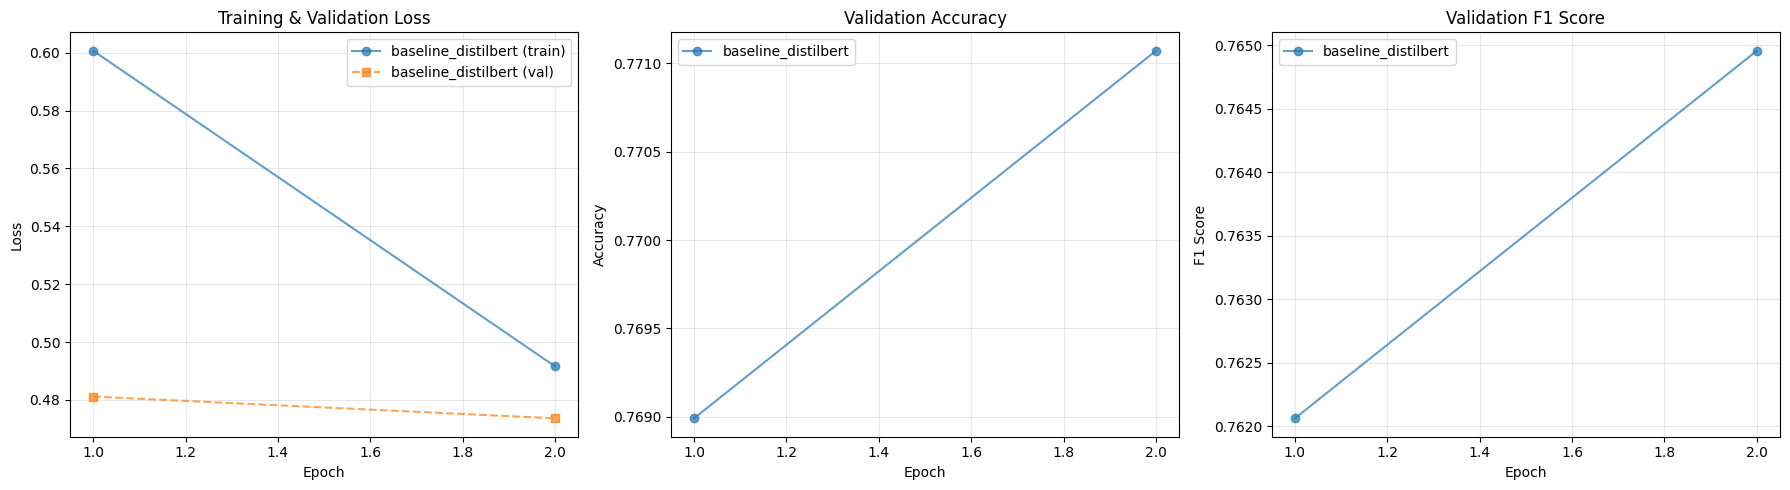

In [ ]:
# Uncomment to use:
plot_training_curves(experiment_ids, save_path="training_curves.png")

Plot saved to metrics_comparison.png


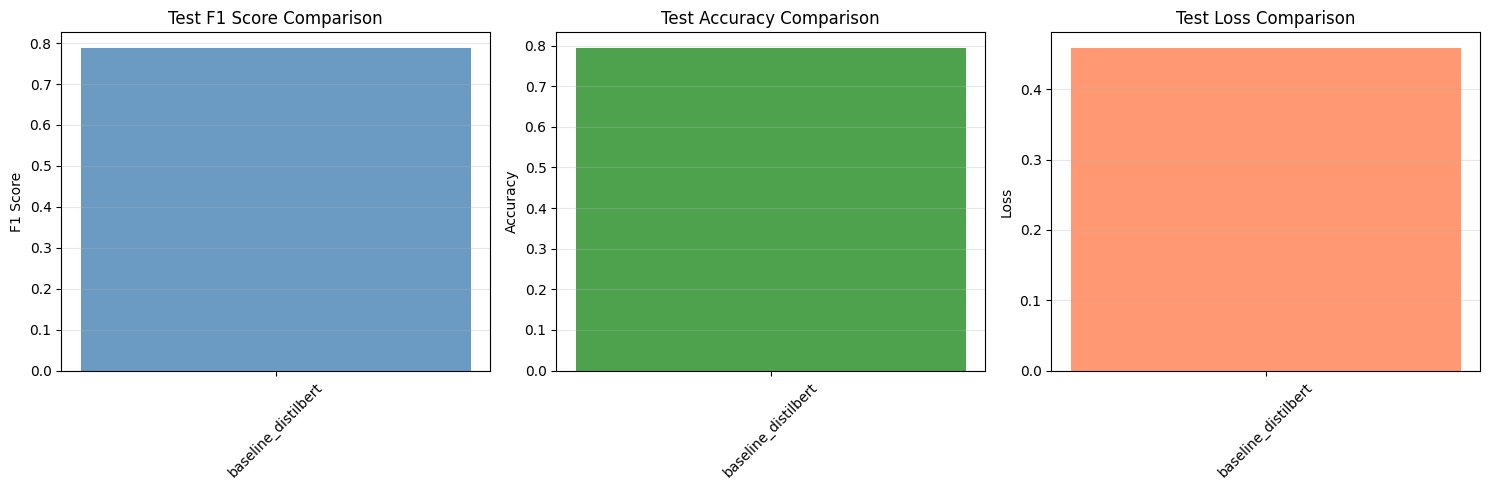

In [ ]:
# Compare final metrics across experiments
plot_metrics_comparison(experiment_ids, save_path="metrics_comparison.png")

Plot saved to bias_comparison.png


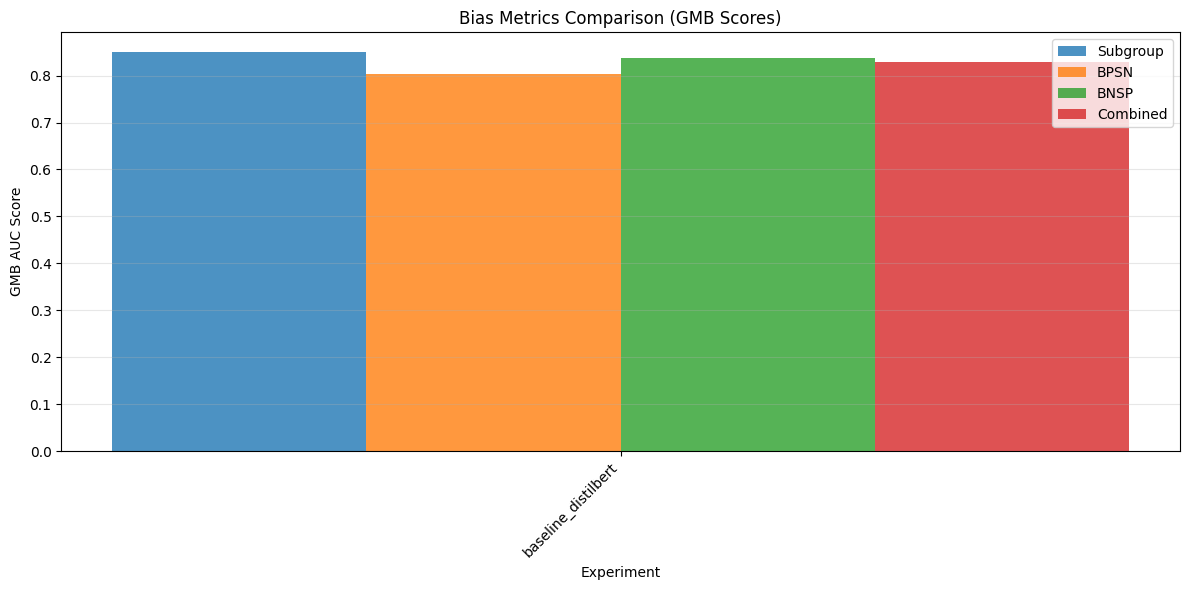

In [ ]:
# Visualize bias metrics
plot_bias_metrics(experiment_ids, save_path="bias_comparison.png")

Plot saved to xai_comparison.png


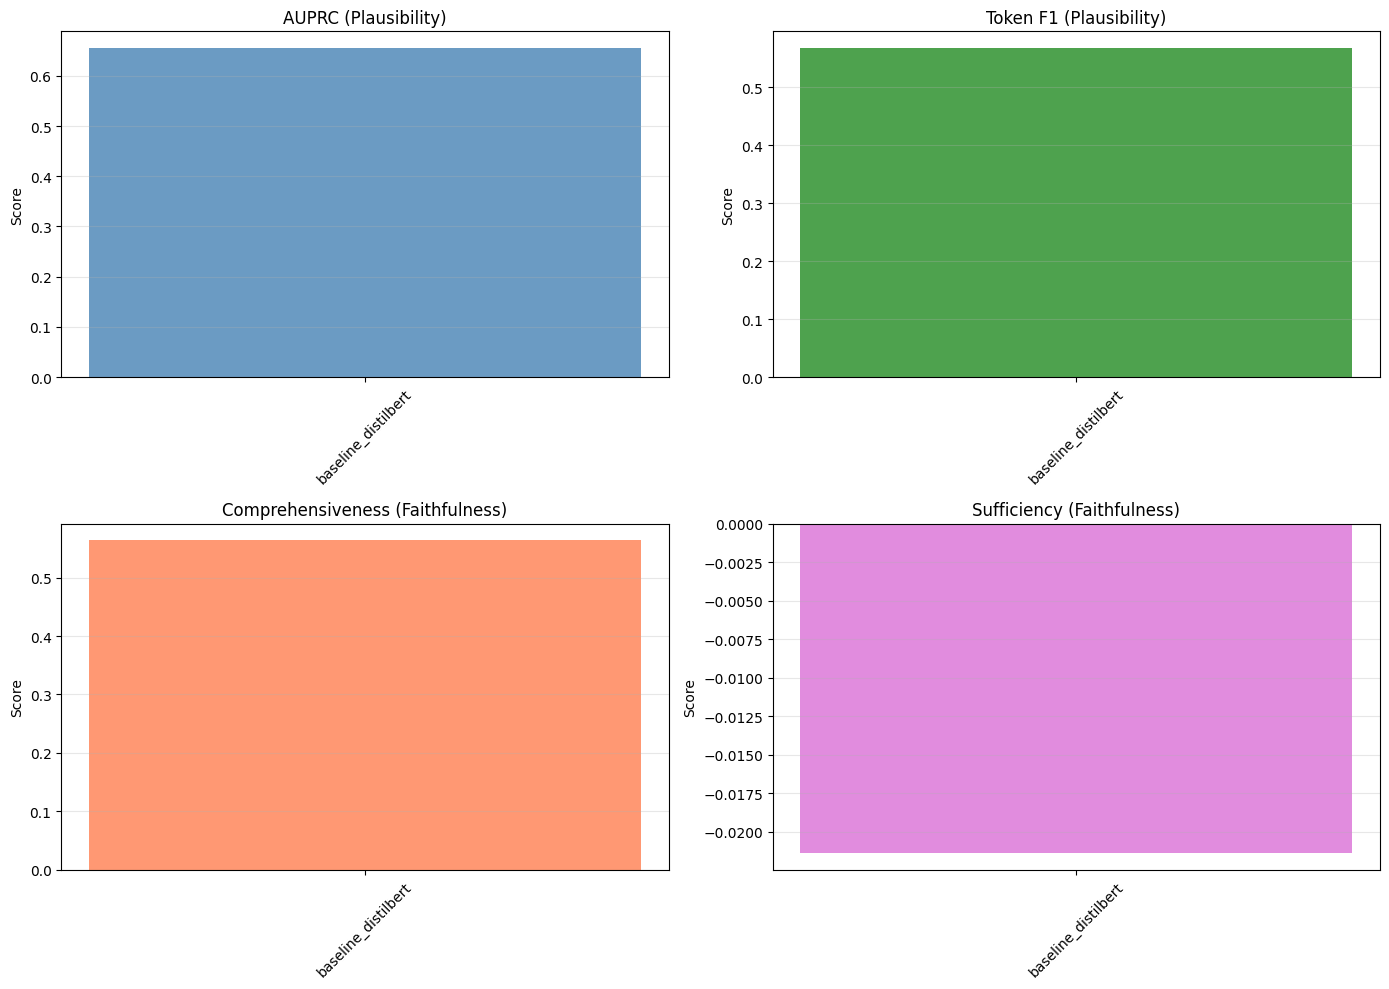

In [ ]:
# Visualize XAI metrics
plot_xai_metrics(experiment_ids, save_path="xai_comparison.png")